# Clustering

Let's begin by loading some basic packages and the Iris dataset, a well-known multivariate dataset with four features describing three classes of flowers.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from pandas.plotting import scatter_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist, pdist
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

## _k_-Means Clustering

*k*-means clustering is a very simple clustering algorithm that iteratively assigns instances to clusters based on how similar they are to other instances nearby.

It is computationally efficient but it only works with numeric data, and deciding the number of clusters can be challenging.

### Clustering Artificial Blobs

To explore _k_-Means clustering, let's make an artificial dataset. We can use `scikit-learn` to generate isotropic Gaussian blobs for clustering.

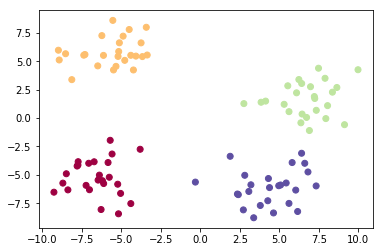

In [2]:
n_blobs = 4

data = datasets.make_blobs(n_samples=100, n_features=2, centers=n_blobs, cluster_std=1.5)

X_blobs = data[0]
y_blobs = data[1]

plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='Spectral');

Let's fit a _k_-Means clustering model with the value `k` set to the number of blobs.

In [3]:
kmeans = KMeans(n_clusters=n_blobs)
kmeans.fit(X_blobs)

y_pred = kmeans.predict(X_blobs)

Now let's make a plot to compare the actual classes and the predicted clusters.

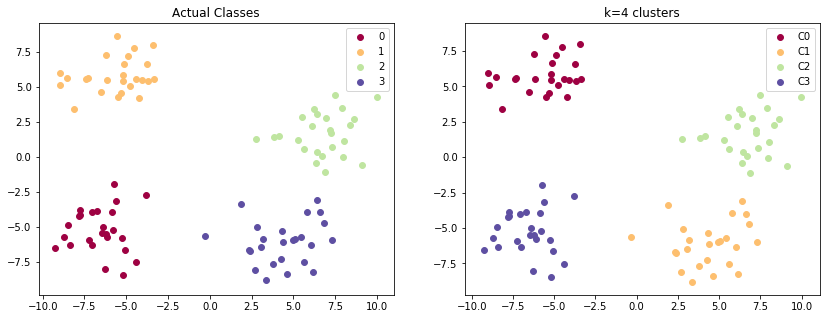

In [4]:
def plot_cluster_pred_vs_true(X, y, y_clusters, n_true):
    """Compare clustering vs. actual."""
    fig = plt.figure(figsize=(14, 5))

    cmap = cm.get_cmap('Spectral')
    colors = cmap(np.linspace(0, 1, n_true))

    ax = fig.add_subplot(121)
    for i in range(n_true):
        idx = y == i
        ax.scatter(X[idx, 0], X[idx, 1], s=35,
                   c=[colors[i]], label='%d'%i)
    plt.legend()
    plt.title('Actual Classes')

    ax = fig.add_subplot(122)
    for i in range(n_true):
        idx = y_clusters == i
        ax.scatter(X[idx, 0], X[idx, 1], s=35,
                   c=[colors[i]], label='C%d'%i)
    plt.legend()
    plt.title('k={:d} clusters'.format(n_true))

    plt.show()


plot_cluster_pred_vs_true(X_blobs, y_blobs, y_pred, n_blobs)

Remember, though, that we specified the value of _k_. How would these results be impacted with a different value of *k*?

We can investigate this question by sweeping over a large number of _k_ values. Here, we'll fit a model for a range of *k* values.

In [5]:
def get_dists(X, centroids):
    """Calculate distance of each instance from nearest centroid."""
    dists = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(dist, axis=1) for dist in dists]
    c_idx = [np.argmin(dist, axis=1) for dist in dists]
    
    return dist, c_idx


def get_metrics(X, dist):
    """Cluster "goodness" metrics."""
    total_within_ss = [sum(d**2) for d in dist]  # total within-cluster sum of squares
    total_ss = sum(pdist(X)**2) / X.shape[0]     # total sum of squares
    between_ss = total_ss - total_within_ss      # between-cluster sum of squares
    
    return total_ss, between_ss


k_max = 10
k_range = range(1, k_max+1)

# Cluster data into k=1..k_max clusters.
ests = [KMeans(n_clusters=k).fit(X_blobs) for k in k_range]

Let's make an elbow plot to examine how these different values of *k* perform.

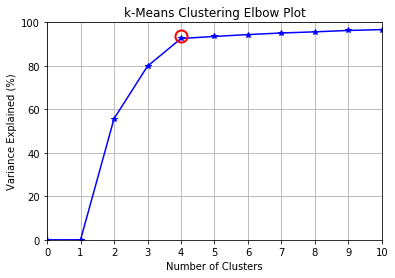

In [6]:
def plot_elbow(k_range, total_ss, between_ss, n_true=None):
    """Plot elbow curve."""
    fig = plt.figure()

    var_exps = (between_ss / total_ss) * 100

    # Add values at 0.
    var_exps = [0] + list(var_exps)
    k_range = [0] + list(k_range)

    ax = fig.add_subplot(111)
    ax.plot(k_range, var_exps, 'b*-')

    if n_true is not None:
        # Add marker for ground truth.
        kwargs = {'marker': 'o', 'markersize': 12, 'markeredgewidth': 2,
                  'markeredgecolor': 'r', 'markerfacecolor': 'None'}
        k_true = k_range[n_true]
        k_true_var_exp = (between_ss[k_true] / total_ss) * 100
        ax.plot(k_true, k_true_var_exp, **kwargs)

    ax.set_xlim((0, k_range[-1]))
    ax.set_ylim((0, 100))
    ax.set_xticks(k_range)

    plt.grid(True)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Variance Explained (%)")
    plt.title("k-Means Clustering Elbow Plot")

    plt.show()


centroids = [est.cluster_centers_ for est in ests]

dist, c_idx = get_dists(X_blobs, centroids)
total_ss, between_ss = get_metrics(X_blobs, dist)

plot_elbow(k_range, total_ss, between_ss, n_true=4)

We can see that the true number of clusters is near the "elbow" in this plot, suggesting it may be useful for deciding the value of _k_.

### Clustering Digits

Now let's load the Digits dataset, a well-known dataset that is composed of handwritten digits between 0 and 9 stretched into a rectangular 16x16 box. Each instance in the dataset has 64 features, representing the individual pixels that comprise the image of a digit.

In [7]:
data = datasets.load_digits()

X_digits = data['data']
y_digits = data['target']

n_digits = len(np.unique(y_digits))

X_digits.shape, y_digits.shape, n_digits

((1797, 64), (1797,), 10)

To help visualize our clusters, we can use PCA to perform dimensionality reduction to reduce the digits dataset from 64 features (dimensions) to 2.

In [8]:
# Perform PCA dimensionality reduction.
pca = PCA(n_components=2).fit(X_digits)
X_pca = pca.transform(X_digits)

In [9]:
k_max = 20
k_range = range(1, k_max+1)

# Cluster data into k=1..k_max clusters.
ests = [KMeans(n_clusters=k).fit(X_pca) for k in k_range]
centroids = [est.cluster_centers_ for est in ests]

dist, c_idx = get_dists(X_pca, centroids)
total_ss, between_ss = get_metrics(X_pca, dist)

We can sweep over a range of _k_ values (here, from 1 to 20) to identify the "elbow" point. The point where *k*=10 is denoted as the elbow point via a red circle in this plot. As there are ten digits in the dataset, the optimal value of *k*-means should ideally be ten.

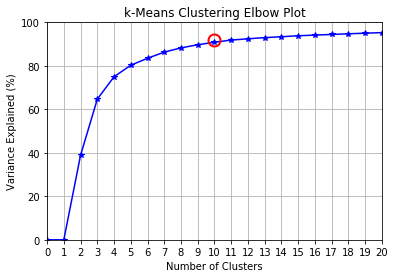

In [10]:
plot_elbow(k_range, total_ss, between_ss, n_true=n_digits)

Finally, we can compare the clusters produced by k-means with ten clusters to the actual classes of the digits.

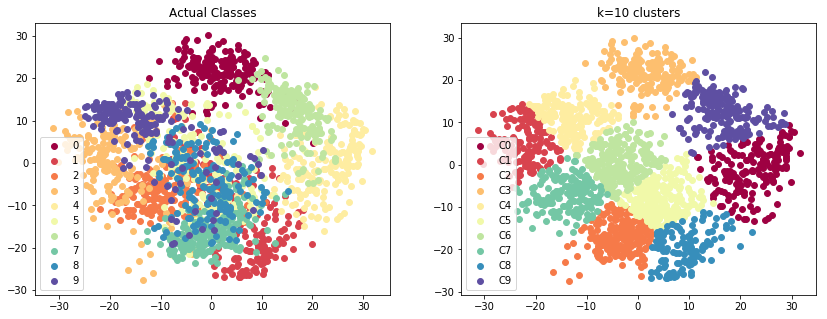

In [11]:
plot_cluster_pred_vs_true(X_pca, y_digits, c_idx[n_digits-1], n_digits)

With k=10 we can extract the particular points that represent the cluster centroids. As we are defining ten clusters, there are ten cluster centroids, one corresponding to each cluster.

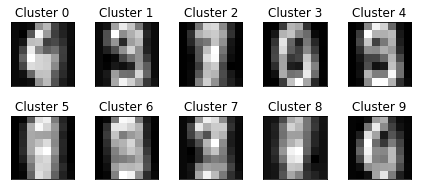

In [12]:
def plot_cluster_centers(centroids, n_true):
    """Plot centroids for k=n_true clusters."""
    fig = plt.figure()
    
    centroids_k = centroids[n_true-1]

    for i in range(n_true):
        img = centroids_k[i].reshape(8, 8)
        ax = plt.subplot(3, 5, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap=cm.gray)
        plt.title("Cluster {:d}".format(i))
        plt.tight_layout()


centroids_inv = [pca.inverse_transform(centroids[k])
                 for k in range(n_digits)]       
plot_cluster_centers(centroids_inv, n_digits)

## Agglomerative Hierarchial Clustering

Agglomerative hierarchical clustering starts with the points as individual clusters and, at each step, merges the closest pair of clusters. As a result, it recursively merges the pair of clusters that minimally increases a given "linkage" distance. The linkage criterion determines the distance between sets of observations as a function of the pairwise distances between observations.

Let's use agglomerative hierarchical clustering to cluster the blobs dataset.

In [13]:
model = AgglomerativeClustering(n_clusters=n_blobs)
model = model.fit(X_blobs)

We can plot a dendrogram to illustrate how each cluster is composed. The cluster draws a link between a non-singleton cluster and its children, with the height of the top of the link representing the distance between its children clusters.

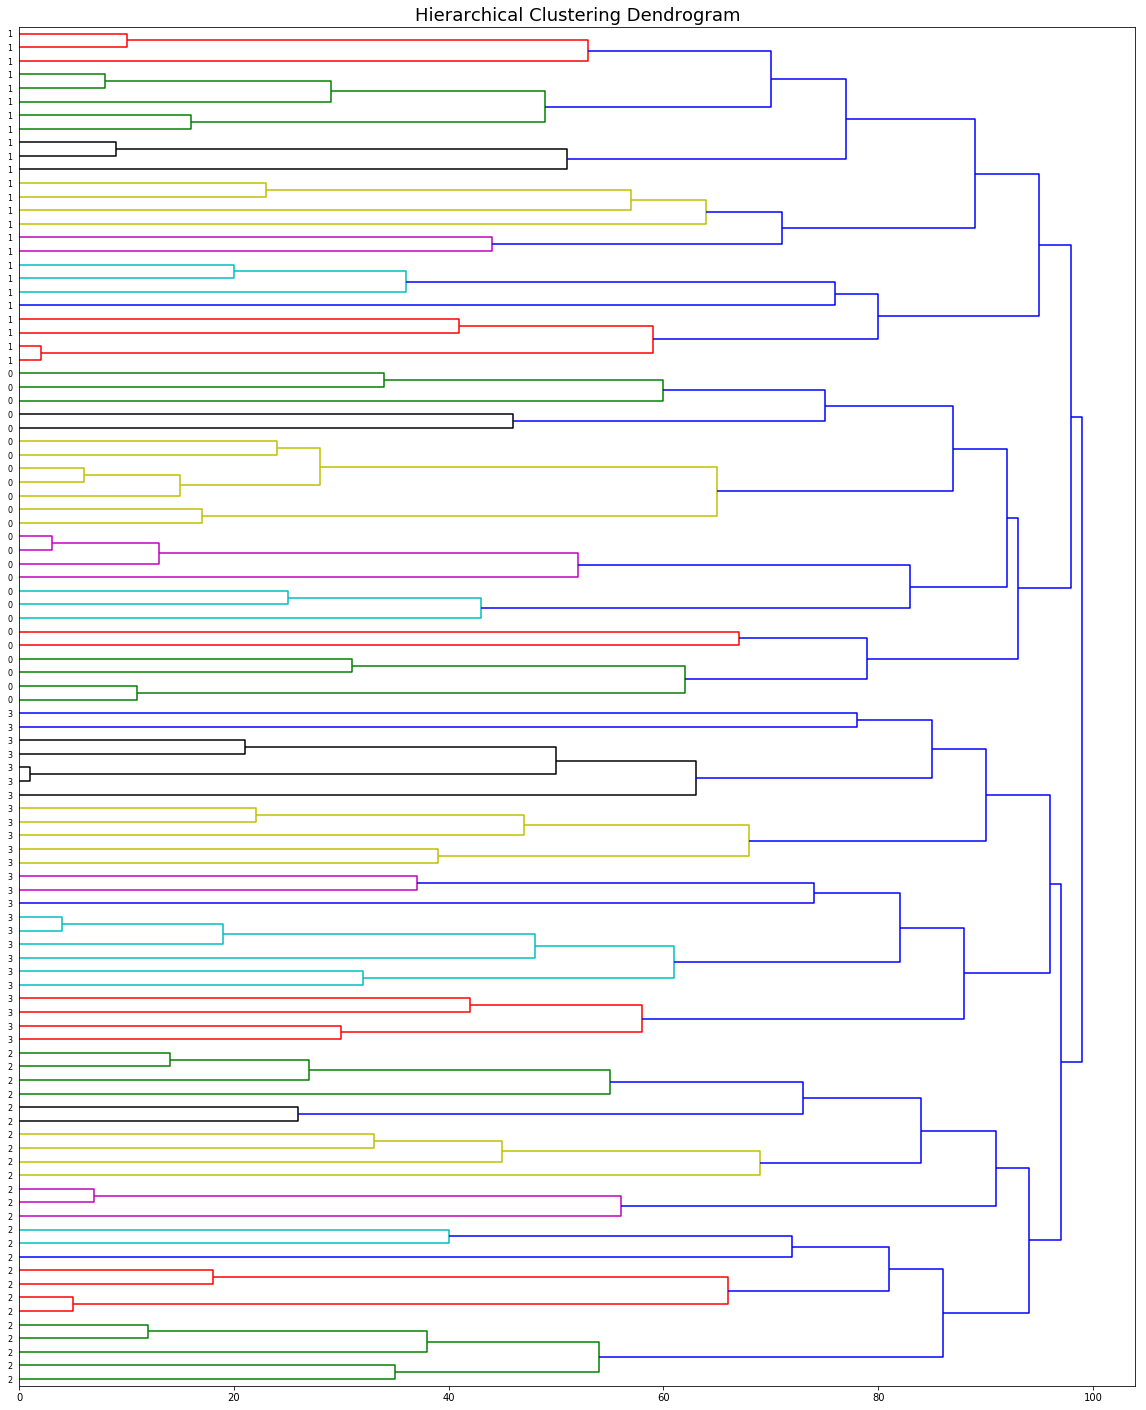

In [14]:
def plot_dendrogram(model, **kwargs):
    children = model.children_
    dist = np.arange(children.shape[0])+1
    n_obs = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, dist, n_obs])
    dendrogram(linkage_matrix.astype(float), **kwargs)

figure = plt.figure(figsize=(20, 25))
plt.title("Hierarchical Clustering Dendrogram", fontsize=18)
plot_dendrogram(model, labels=y_blobs, orientation='right', leaf_font_size=8)
plt.show()